# Mode Cleaner design notebook
Calculate the transmission of the mode cleaner (MC), find the ideal parameters of the cavity (Length, Finesse, RoC) and calculate the losses and characteristics of the circulating beam.

In [1]:
# import the required libraries
import matplotlib.pyplot as plt
import numpy as np
import MC_design_functions as MCdf
import sys
plt.style.use('ggplot')

## Pound–Drever–Hall (PDH) technique
Plot a two-mirror Fabry–Perot cavity reflection transfer function and a PDH readout signal.

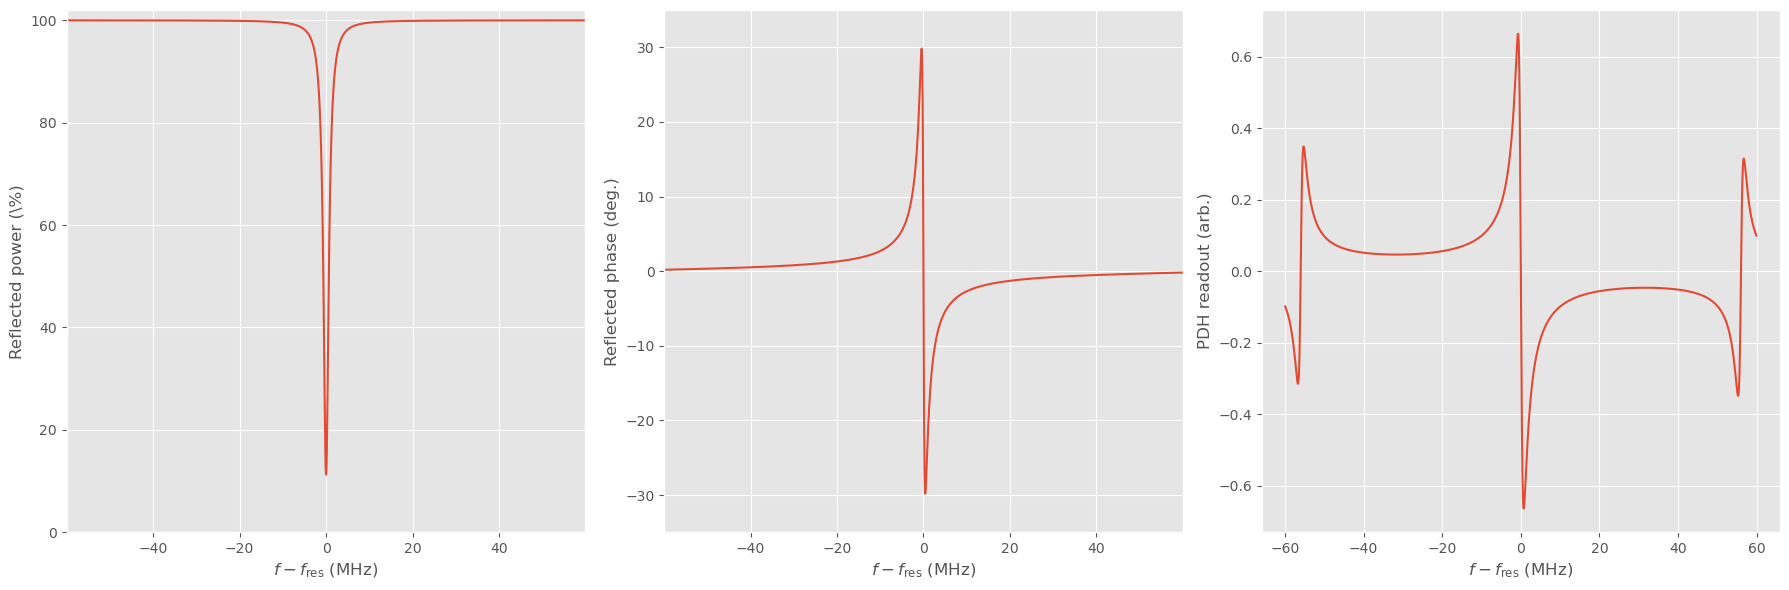

In [2]:
# Call the function with the desired parameters
L = 1.  # length of the optical cavity
fm = 56e6  # frequency of the sideband signal
r1 = .99  # input mirror reflectivity
r2 = .98  # end mirror reflectivity

f, R, pdh, fsr = MCdf.PDH(L, fm,r1,r2)

# Set up subplots and plot the results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot Reflected power
axes[0].plot(f/1e6, 100*np.abs(R)**2)
axes[0].axis([-.4*fsr/1e6, .4*fsr/1e6, 0, 102])
axes[0].set_ylabel('Reflected power (\%)')
axes[0].set_xlabel('$f-f_\mathrm{res}$ (MHz)')

# Plot Reflected phase
axes[1].plot(f/1e6, 180*np.angle(R)/np.pi)
axes[1].axis([-.4*fsr/1e6, .4*fsr/1e6, -35, 35])
axes[1].set_ylabel('Reflected phase (deg.)')
axes[1].set_xlabel('$f-f_\mathrm{res}$ (MHz)')

# Plot PDH readout
axes[2].plot(f/1e6, np.imag(pdh))
axes[2].set_ylabel('PDH readout (arb.)')
axes[2].set_xlabel('$f-f_\mathrm{res}$ (MHz)')

plt.tight_layout()  # Adjust the layout to avoid overlapping
plt.show()

## Plot the transmission of a MC from the parameters

In [10]:
# Constants
c = 2.99792e8 # Speed of light
carrier = 1064e-9 # Carrier wavelength (m)
f = c / carrier # Carrier frequency (Hz)
fm = [6e6, 56e6] # Sidebands frequency (Hz)
R1, R2 = 0.99, 0.99 # Mirrors reflectivity
n = 1.45 # Cavity index
sidebands_trans_min, TEM_limit = 0.90, 0.01 # Sidebands & HOMs transmissions limits
L_lim, F_lim = [5e-2, 30e-2], [5, 50] # Length (m) & finesse limits
nm_max = 10 # Number of HOMs to consider

F = 10
FL_lim=[0,0]; rL_lim=[0,0]

print("-----Parameters intervals-----")
## Losses limitations
losses_max=1/100; P=10/1000000
F_lim[1]=np.pi*losses_max/(4*P)
if F_lim[1]<F_lim[1]: F_lim[1]=F_lim[1]
print(round(F_lim[0],4),"<F<",round(F_lim[1],4))

## Sidebands transmission
FL_lim[1]=np.sqrt(((1-sidebands_trans_min)*c**2)/(16*sidebands_trans_min*fm[1]**2))
FL_lim[0]=L_lim[0]*F_lim[0]
L_lim[1]=FL_lim[1]/F_lim[0]
print(round(L_lim[0]*1e2,4),"<L (cm)<",round(L_lim[1]*1e2,4))

## Filtering of higher modes
rL_lim[1]=TEM_limit*(2*FL_lim[1]/(n*np.pi))**2
r_min=rL_lim[1]/L_lim[1]; r_max=rL_lim[1]/L_lim[0]
g_min=np.cos(1/n)**2 # From the conditions that the max n+m TEM should not go above the FSR
print(round(g_min,4),"<g<",round(1-L_lim[0]/r_max,4))

-----Parameters intervals-----
5 <F< 785.3982
FL_max= 0.4461190476190476
5.0 <L (cm)< 8.9224
0.5952 <g< -5.5165


-----Parameters-----
Length (cm)= 8.922362892496297
Finesse= 10
g= 0.9251589632555218

-----Transmissions-----
SBs transmissions: [0.9949240902346955, 0.6930869538765015]
HOMs transmissions: [1.0, 0.24794251282884264, 0.08180131295606188, 0.04324811924312066, 0.029883057797649198, 0.02490470385160372, 0.024279092268008007, 0.027580139765181595, 0.03725829622525405, 0.0634829393054047, 0.15835426666488875]
df (MHz)= 148.1843934681287


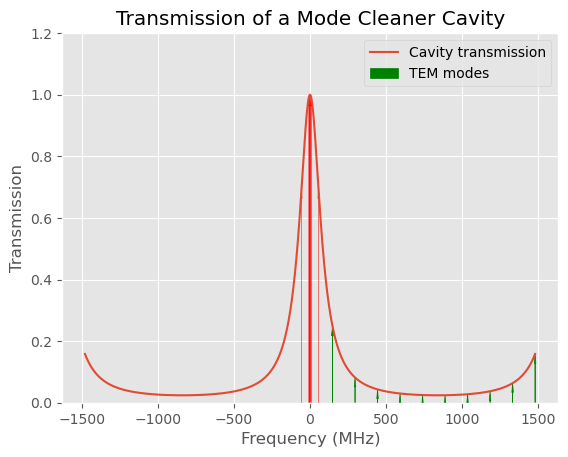

In [9]:
g = MCdf.get_optimal_g(g_min, nm_max, F) # Determine the best g to attenuate the higher order TEM
Ls = MCdf.get_lengths(L_lim, carrier, g) # Carrier transmission, find the possibilities between L_lim
L = Ls[-1]  #We keep the bigger one for now

print("-----Parameters-----")
print("Length (cm)=", L*1e2)
print("Finesse=", F)
print("g=", g) # g=1-F/RoC
print()

# Transmissions
T = [MCdf.Airy(F, L, freq) for freq in fm] # of the SBs
TEM = [MCdf.Tnm(F, g, i) for i in range(nm_max + 1)] # of the TEM modes
df = np.arccos(np.sqrt(g)) * c / (2 * np.pi * L) # frequency difference between TEM modes (due to the Gouy phase)

print("-----Transmissions-----")
print("SBs transmissions:",T)
print("HOMs transmissions:",TEM)
print("df (MHz)=", df/1e6)

# Plotting
MCdf.plot_transmission(n, L, F, g, fm, nm_max)


## Studies of the higher order modes transmission with the RoC

L (cm)= 0.3875
Ideal RoC (m)= 0.090448


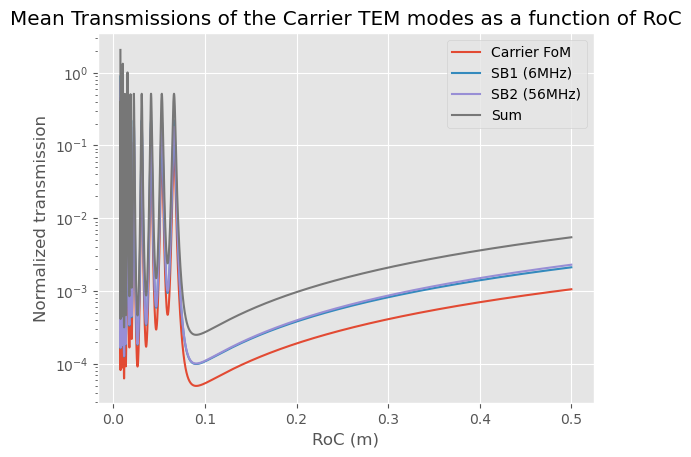

In [2]:
# Input parameters
idxn = 1.44963
length = 0.06200 / 16
lopt = 2 * idxn * length
print("L (cm)=", length * 10**2)

fmod1 = 6.270777e6
fm = [fmod1, fmod1*9]
lambda_ = 1064.0e-9

Pcar = 1
Psb = [1, 1]
PmodeCar = np.ones(10)
PmodeSb1 = np.full(10, 2)
PmodeSb2 = np.full(10, 2)

SB_limit = 0.90

# Call the function with the input parameters
rho_vect, FoM_vect_car, FoM_vect_SB, FoM_vect_sum, ideal_roc, Fomc = MCdf.calculate_transmissions(idxn, length, fmod1, fm, lambda_, Pcar, Psb, PmodeCar, PmodeSb1, PmodeSb2, SB_limit)

print("Ideal RoC (m)=", ideal_roc)

# Plotting
plt.figure()
plt.plot(rho_vect, FoM_vect_car, label='Carrier FoM')
plt.plot(rho_vect, FoM_vect_SB[0], label='SB1 (6MHz)')
plt.plot(rho_vect, FoM_vect_SB[1], label='SB2 (56MHz)')
plt.plot(rho_vect, FoM_vect_sum, label='Sum')
plt.xlabel('RoC (m)')
plt.ylabel('Normalized transmission')
plt.yscale('log')
plt.title('Mean Transmissions of the Carrier TEM modes as a function of RoC')
plt.legend()
plt.show()


Ideal RoC (m)= 0.090448
g= 0.9571577038740492


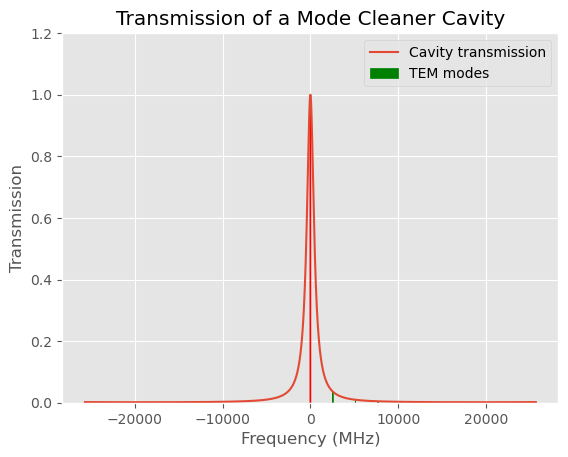

Waist size (m): 0.00030019790182349927
Circ power (W): 49.74874371859289


In [6]:
FoM_vect_sum=FoM_vect_car+FoM_vect_SB[0]+FoM_vect_SB[1]
r=rho_vect[np.argmin(FoM_vect_sum)] # Ideal RoC
print("Ideal RoC (m)=", r)
g=(1-length/r)
print("g=",(1-length/r))
MCdf.plot_transmission(idxn, length, Fomc, g, fm, 10)

ideal_RoC = rho_vect[np.argmin(FoM_vect_sum)]
waist = MCdf.waist_size(lopt, ideal_RoC, lambda_,idxn)
print("Waist size (m):", waist)

P_input = 1.0  # Input power in Watts
max_pwr = MCdf.circ_power(P_input)
print("Circ power (W):", max_pwr)

#RoC2 = 0.6  # Second radius of curvature in meters, example value
#astig_loss = astigmatism_losses(lopt, ideal_RoC, RoC2, lambda_)
#print("Astigmatism losses:", astig_loss)